In [1]:
import json
import numpy as np
import pandas as pd

In [2]:
stopwords = []

In [3]:
def load_data(input_name):
    
    with open(input_name, 'r') as f:
        T = f.read().split('\n')
        
    Q = int(T[0])
    questions = T[1:Q+1]
    D = int(T[Q+1])
    labels = T[Q+2:Q+2+D]
    to_predict = T[Q+3+D:-1]
    
    y = [int(row.split()[2]) for row in labels]
    keys = [row.split()[:2] for row in labels]
    
    return questions, keys, to_predict, y

In [4]:
questions, keys, to_predict, y = load_data('input/input00.txt')

In [5]:
def turn_into_dict_by_keys(questions):
    qdict = {}
    
    for q in questions:
        
        q = json.loads(q)
        key = q.pop('question_key')
        qdict[key] = q
        
    return qdict

In [6]:
qdict = turn_into_dict_by_keys(questions)

In [7]:
def extract(qdict, labels):
    
    features = ['age', 'follow_count', 'view_count', 'context_topic']
    
    texts = []
    feats = []
    topics = []
    
    for lab in labels:
        
        lab = lab.split()
        q1 = qdict[lab[0]]
        q2 = qdict[lab[1]]
        txt = [q1['question_text'], q2['question_text'], int(lab[-1])]
        texts.append(txt)
        
        ft = [{k:q1[k] for k in features}, {k:q2[k] for k in features}, int(lab[-1])]
        feats.append(ft)
        
        tp = [q1['topics'], q2['topics'], int(lab[-1])]
        topics.append(tp)
        
        
    return texts, feats, topics

In [8]:
def extract_test(qdict):
    
    features = ['age', 'follow_count', 'view_count', 'context_topic']
    
    texts = []
    feats = []
    topics = []
    
    for lab in labels:
        
        lab = lab.split()
        q1 = qdict[lab[0]]
        q2 = qdict[lab[1]]
        txt = [q1['question_text'], q2['question_text']]
        texts.append(txt)
        
        ft = [{k:q1[k] for k in features}, {k:q2[k] for k in features}]
        feats.append(ft)
        
        tp = [q1['topics'], q2['topics']]
        topics.append(tp)
        
        
    return texts, feats, topics

In [9]:
import re

In [10]:
cleaner = re.compile(r'[^a-z0-9 ]')

In [11]:
def purge(x, space=False):
    x = x.lower()
    x = cleaner.sub(' ' if space else '', x)
    return x

In [12]:
from collections import defaultdict

In [13]:
def calc_tfidf(qlist, n_gram=1, max_features=None, stopwords=set(), token_frequency=defaultdict(int)):
    
    """
    
    liczymy częstotliwość występowania konkretnych tokenów dla listy pytań
    
    ZAKŁADAMY, ŻE SĄ JUŻ WYCZYSZCZONE
    
    """
    
    
    tfs = []
    
    for q in qlist:
        
        q = [x for x in q.split() if x not in stopwords]
        c = len(q)
        tokens = [' '.join(q[i:i+n_gram]) for i in range(c-n_gram+1)]
        
        if not isinstance(token_frequency, str):
            for token in set(tokens):
                token_frequency[token] += 1
            
        tfs.append(tokens)
            
    return token_frequency, tfs

def process_token_frequency(token_frequencies, n_questions):
    
    for k, v in token_frequencies.items():
        
        token_frequencies[k] = np.log10(n_questions/(1+v))
        
    return token_frequencies

def calc_overlap(q1tokens, q2tokens, token_idf):
    
    """
    
    liczymy część wspólną tokenów, zarówno zwykłą jak i wynikającą z idf
    
    ZAKŁADAMY, ŻE token_idf JEST PODDANE ZLOGARYTMOWANIU, ODWRÓCENIU ETC.
    
    """
    
    assert len(q1tokens) == len(q2tokens)
    
    N = len(q1tokens)
    
    colnames = ['common_score', 'tfidf_score', 'max_outsider', 'mean_outsider']
    scores = []
    
    for i in range(N):
        
        q1_tokens = q1tokens[i]
        q2_tokens = q2tokens[i]
        
        if len(q1_tokens) == 0 and len(q2_tokens) == 0:
            scores.append([0]*len(colnames))
            continue
        
        common_score = len([x for x in q1_tokens if x in q2_tokens]) + len([x for x in q2_tokens if x in q1_tokens])
        common_score /= len(q1_tokens) + len(q2_tokens)
        idf_score = sum([token_idf[x] for x in q1_tokens if x in token_idf and x in q2_tokens]) + \
        sum([token_idf[x] for x in q2_tokens if x in q1_tokens and x in token_idf])
        idf_denom = sum([token_idf[x] for x in q2_tokens if x in token_idf]) + \
        sum([token_idf[x] for x in q1_tokens if x in token_idf])
        idf_score /= idf_denom if idf_denom else 1
        
        
        outsiders = [token_idf[x] for x in q1_tokens if x in token_idf and x not in q2_tokens] + \
                           [token_idf[x] for x in q2_tokens if x in token_idf and x not in q1_tokens]
            
        max_outsider = max(outsiders) if len(outsiders) else 0
        mean_outsider = np.mean(outsiders) if len(outsiders) else 0
        
        scores.append([common_score, idf_score, max_outsider, mean_outsider])
        
    return scores

def get_train_scores(text_df, n_grams=1, max_features=None, stopwords=stopwords):
    tf, q1_tokens = calc_tfidf(text_df['q1'].apply(purge), stopwords=set(stopwords), 
                               n_gram=n_grams, max_features=max_features)
    tf, q2_tokens = calc_tfidf(text_df['q2'].apply(purge), stopwords=set(stopwords), 
                               token_frequency=tf, n_gram=n_grams, max_features=max_features)
    tf = process_token_frequency(tf, text_df.shape[0])
    colnames = ['common_score', 'tfidf_score', 'max_outsider', 'mean_outsider']
    return pd.DataFrame(calc_overlap(q1_tokens, q2_tokens, tf), 
                        columns=['{n}_{w}'.format(n=n_grams, w=w) for w in colnames]), tf

def get_test_scores(text_df, token_freq, n_grams=1, max_features=None, stopwords=stopwords):
    tf, q1_tokens = calc_tfidf(text_df['q1'].apply(purge), stopwords=set(stopwords), 
                               n_gram=n_grams, max_features=max_features, token_frequency='test')
    tf, q2_tokens = calc_tfidf(text_df['q2'].apply(purge), stopwords=set(stopwords), 
                               token_frequency='test', n_gram=n_grams, max_features=max_features)
    colnames = ['common_score', 'tfidf_score', 'max_outsider', 'mean_outsider']
    return pd.DataFrame(calc_overlap(q1_tokens, q2_tokens, token_freq), 
                        columns=['{n}_{w}'.format(n=n_grams, w=w) for w in colnames]), tf

def get_question_text_by_key(series, qdict):
    
    return pd.DataFrame(data=[[qdict[row[0]]['question_text'], qdict[row[1]]['question_text']] for row in series], columns=['q1', 'q2'])

In [14]:
from sklearn.base import TransformerMixin

In [15]:
def get_topic_idfs(labels):
    
    
    topic_freq = defaultdict(int)
    
    for lab in labels:
        
        for t in lab:

            for ds in t:

                topic_freq[ds['name']] += 1
                
    return topic_freq

def calc_topic_overlap(topics, topic_idfs):
    
    scores = []
    
    for top in topics:
        
        t1, t2 = top
        
        t1 = [x['name'] for x in t1]
        t2 = [x['name'] for x in t2]
        
        all_tops = set(t1) | set(t2)
        mutual_tops = set(t1) & set(t2)
        
        if len(all_tops) == 0:
            scores.append([0, 0, 0, 0, 0])
            continue
        
        denominator = sum([topic_idfs[x] for x in t1] + [topic_idfs[x] for x in t2])
        numerator = sum([topic_idfs[x] for x in t1 if x in t2] + [topic_idfs[x] for x in t2 if x in t1])
        
        outsiders = [topic_idfs[x] for x in t1 if x in topic_idfs and x not in t2] + \
        [topic_idfs[x] for x in t2 if x in topic_idfs and x not in t2]
        l = len(outsiders)
        ma = max(outsiders) if l else 0
        me = np.mean(outsiders) if l else 0
        
        
        scores.append([len(mutual_tops)/len(all_tops), numerator/denominator if denominator else 0, 
                       len(mutual_tops), ma, me])
        
    return pd.DataFrame(scores, columns=['comm_tops', 'idf_tops', 'mutual_cnt', 'max_outsiders', 'mean_outsiders'])

In [16]:
from collections import Counter

In [17]:
def get_topic_words_idf(qdict, n_grams=1, filt = lambda x: purge(x, space=True), training=False):
    
    word_frequencies = defaultdict(int)
    topics = {}
    
    for k, v in qdict.items():
        
        this_topic = Counter()
        top = v['topics']
        for ds in top:
            grams = filt(ds['name']).split()
            c = len(grams)
            grams = [' '.join(grams[i:i+n_grams]) for i in range(c-n_grams+1)]
            this_topic.update(dict(zip(grams, [1]*len(grams))))
            del this_topic['']
            
        if training:
            for word in this_topic.keys():

                word_frequencies[word] += 1
            
        topics[k] = this_topic
            
    return word_frequencies, topics

def calc_words_in_topic_overlap(labels, topics, topic_grams_idf, n_gram):
    
    scores = []
    
    for q in labels:
        
        q1_sum = sum(topics[q[0]].values())
        q2_sum = sum(topics[q[1]].values())
        
        if q1_sum == 0 and q2_sum == 0:
            scores.append([0, 0, 0, 0])
            continue
        
        q1_scores = {k:v/q1_sum for k, v in topics[q[0]].items()}
        q2_scores = {k:v/q2_sum for k, v in topics[q[1]].items()}
        
        q1_scores = {k:v*topic_grams_idf[k] for k, v in q1_scores.items()}
        q2_scores = {k:v*topic_grams_idf[k] for k, v in q2_scores.items()}
        
        occurence_score = sum([topics[q[0]][x] for x in topics[q[0]].keys() if x in topics[q[1]]]) + \
            sum([topics[q[1]][x] for x in topics[q[1]].keys() if x in topics[q[0]]])
        occurence_score /= q1_sum + q2_sum
        
        tfidf_score = sum([q1_scores[x] for x in q1_scores.keys() if x in q2_scores]) + \
            sum([q2_scores[x] for x in q2_scores.keys() if x in q1_scores])
        tfidf_denom = sum(q1_scores.values()) + sum(q2_scores.values())
        if tfidf_denom:
            tfidf_score /= sum(q1_scores.values()) + sum(q2_scores.values())
            
        outsiders = [q1_scores[x] for x in q1_scores.keys() if x not in q2_scores] + \
        [q2_scores[x] for x in q2_scores.keys() if x not in q1_scores]
            
        l = len(outsiders)
        ma = max(outsiders) if l else 0
        mo = np.mean(outsiders) if l else 0
        
        scores.append([occurence_score, tfidf_score, ma, mo])
        
    return pd.DataFrame(scores, columns=['{}_{}'.format(n_gram, w) for w in ['occurence', 'tfidf', 'max_out', 'mean_out']])

In [18]:
def get_popularity_features(qdict):
    
    pop_feats = {}
    for k, v in qdict.items():
        
        topic_followers = [x['followers'] for x in v['topics']]
        empty =  len(topic_followers) == 0
        this = {'age':v['age'], 'follow_count':v['follow_count'], 'view_count':v['view_count'],
                'max_followers': max(topic_followers) if not empty else -1, 'min_followers': min(topic_followers) if not empty else -1, 
                'mean_followers': np.mean(topic_followers) if not empty else -1}
        pop_feats[k] = this
        
    return pop_feats

In [19]:
def compare_popularity(pop_feats, labels, sq_quot=np.log10, sq_cnt=np.log1p):
    
    keys = ['age', 'follow_count', 'view_count', 'max_followers', 'min_followers', 'mean_followers']
    
    scores = []
    
    for lab in labels:
        
        this = {}
        for key in keys:
            
            cnts = np.asarray([pop_feats[x][key] for x in lab])
            
            if np.any(cnts==0) or np.any(cnts==-1):
                this[key] = -1
                this[key+'_reverse'] = -1
            else:
                this[key] = sq_quot(sq_cnt(cnts[0])/sq_cnt(cnts[1]))
                this[key+'_reverse'] = sq_quot(sq_cnt(cnts[1])/sq_cnt(cnts[0]))
                
                
        scores.append(this)
        
    return pd.DataFrame(scores)

In [20]:
def truncate_dict(qdict, labels):
    
    new_dict = {}
    for row in labels:
        
        q1, q2 = row
        new_dict[q2] = qdict[q2]
        new_dict[q1] = qdict[q1]
        
    return new_dict

In [21]:
def words_topics_pipeline(qdict, labels, n_grams):
    
    word_frequencies, topics_gram = get_topic_words_idf(qdict, n_grams=n_grams, training=True)
    word_frequencies = process_token_frequency(word_frequencies, n_questions=len(labels))
    return calc_words_in_topic_overlap(labels, topics_gram, word_frequencies, n_grams)

In [243]:
class MyVectorizer(TransformerMixin):
    
    def fit_transform(self, X, y=None):
        return self._train_scores(X)
    
    def transform(self, X):
        
        return self._retrieve_scores(X)
    
    def fit(self, X, y=None):
        
        self._train_scores(X)
        return self 
    
    def get_feature_names(self):
        
        return self.feats
    
    def get_params(self, deep=True):
        return {}

In [267]:
class StatsVectorizer(MyVectorizer, TransformerMixin):
    
    def __init__(self, qdict, sq_quot=np.log10, sq_cnt=np.log1p):
        
        self.qdict = qdict
        self.sq_quot = sq_quot
        self.sq_cnt = sq_cnt
        
    def _calculate_score(self, labels):
        
        new_dict = truncate_dict(self.qdict, labels)
        pop_feats = get_popularity_features(new_dict)
        pop_score = compare_popularity(labels=labels, pop_feats=pop_feats, sq_cnt=self.sq_cnt, sq_quot=self.sq_quot)
        self.feats = pop_score.columns
        return pop_score
    
    def _train_scores(self, labels):
        return self._calculate_score(labels)
    
    def _retrieve_scores(self, labels):
        return self._calculate_score(labels)
    
    def get_params(self, deep=True):
        return {'qdict':self.qdict, 'sq_quot':self.sq_quot, 'sq_cnt':self.sq_cnt}

In [261]:
class WordInTopicVectorizer(MyVectorizer, TransformerMixin):
    
    def __init__(self, qdict, n_grams):
        
        self.qdict = qdict
        self.n_grams = n_grams
        
    def _train_scores(self, labels):
        
        new_dict = truncate_dict(self.qdict, labels)
        word_frequencies, topics_gram = get_topic_words_idf(new_dict, n_grams=self.n_grams, training=True)
        self.word_frequencies = process_token_frequency(word_frequencies, n_questions=len(labels))
        scores = calc_words_in_topic_overlap(labels, topics_gram, self.word_frequencies, self.n_grams)
        self.feats = scores.columns
        return scores
    
    def _retrieve_scores(self, labels):
        
        new_dict = truncate_dict(self.qdict, labels)
        _, topics_gram = get_topic_words_idf(new_dict, n_grams=self.n_grams, training=False)
        return calc_words_in_topic_overlap(labels, topics_gram, self.word_frequencies, self.n_grams)
    
    def get_params(self, deep=True):
        return {'n_grams':self.n_grams, 'qdict':self.qdict}

In [262]:
class TopicVectorizer(MyVectorizer, TransformerMixin):
    
    def __init__(self, qdict):
        
        self.qdict = qdict
        
    def _train_scores(self, labels):
        
        relevant_topics = [[self.qdict[row[0]]['topics'], self.qdict[row[1]]['topics']] for row in labels]
        
        topic_freq = get_topic_idfs(relevant_topics)
        topic_freq = process_token_frequency(topic_freq, len(relevant_topics))
        score_df = calc_topic_overlap(relevant_topics, topic_freq)
        
        self.topic_freq = topic_freq
        self.feats = score_df.columns
        return score_df
    
    def _retrieve_scores(self, labels):
        
        relevant_topics = [[self.qdict[row[0]]['topics'], self.qdict[row[1]]['topics']] for row in labels]
        score_df = calc_topic_overlap(relevant_topics, self.topic_freq)
        
        return score_df
    
    def get_params(self, deep=True):
        return {'qdict':self.qdict}

In [263]:
class QuestionTextVectorizer(MyVectorizer, TransformerMixin):
    
    def __init__(self, n_grams, qdict, stopwords=[]):
        
        self.n_grams = n_grams
        self.stopwords = stopwords
        self.qdict = qdict
        
    def _train_scores(self, question_ids):
        
        text_df = get_question_text_by_key(question_ids, self.qdict)
        score_df, token_freq = get_train_scores(text_df, self.n_grams, stopwords=self.stopwords)
        token_freq = process_token_frequency(token_freq, n_questions=len(question_ids))
        self.token_freq = token_freq
        self.feats = score_df.columns
        
        return score_df
    
    def _retrieve_scores(self, question_ids):
        
        text_df = get_question_text_by_key(question_ids, self.qdict)
        score_df, token_freq = get_test_scores(text_df, self.token_freq, self.n_grams, stopwords=self.stopwords)
        
        return score_df
    
    def get_params(self, deep=True):
        
        return {'n_grams': self.n_grams, 'stopwords': self.stopwords, 'qdict':self.qdict}

In [27]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [28]:
def test_features_by_permutation(clf, X, y, shuffles):
    
    diffs = []
    N = X.shape[1]
    clf.fit(X, y)
    ref_score = (clf.predict(X)==y).mean()
    
    def train_and_test(clf, X, y, n, shuffles):
        
        X_t = X.copy()
        scores = []
        for i in range(shuffles):
            np.random.shuffle(X_t[:, n])
            scores.append((clf.predict(X_t)==y).mean())
            
        return (n, np.mean(scores))
    
    diffs = [train_and_test(clf, X, y, i, shuffles) for i in range(N)]
    return [(x[0], ref_score-x[1], x[1]) for x in diffs]

In [29]:
def plot_hist(score_df, col, bins=100, ylim=1000, subplot=111, y=y, label_one='duplicates', label_zero='not duplicates'):
    
    ones = y == 1
    zeros = y == 0
    
    ax = plt.subplot(subplot)
    plt.hist(score_df[col].as_matrix()[ones], color='red', alpha=.5, label=label_one, bins=bins)
    plt.hist(score_df[col].as_matrix()[zeros], color='blue', alpha=.5, label=label_zero, bins=bins)
    plt.legend(loc='best')
    ax.set_yscale('log')
    if ylim is not None:
        plt.ylim(0, ylim)
    if subplot == 111:
        plt.show()

In [30]:
def paint_histograms(pip, X, y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, np.asarray(y), test_size=.2)
    
    pip.fit(x_train, y_train)
    
    transformed = pip.steps[0][1].transform(x_train)
    
    plt.figure(figsize=(12,9))
    
    N = transformed.shape[1]
    mod = N%2
    subplot = '{cols}{rows}'.format(cols=N//2 + mod, rows=N//2) + '{}'
    cols = transformed.columns
    for i in range(N):
        
        col = cols[i]
        plot_hist(transformed, col, subplot=subplot.format(i+1), ylim=None, y=y_train)

        plt.title(col)
        
    
    correct = (pip.predict(x_test) == y_test)
    
    
    plt.figure(figsize=(12,9))
    for i in range(N):
        
        col = cols[i]
        plot_hist(pip.steps[0][1].transform(x_test), col, subplot=subplot.format(i+1), ylim=None, y=correct, label_one='correct', label_zero='wrong')

        plt.title(col)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
def identity(x):
    return x

In [33]:
from sklearn.pipeline import make_union

In [35]:
all_features = union.fit_transform(keys)

In [36]:
columns = np.hstack([x[1].feats for x in union.transformer_list])

In [40]:
from matplotlib import pyplot as plt

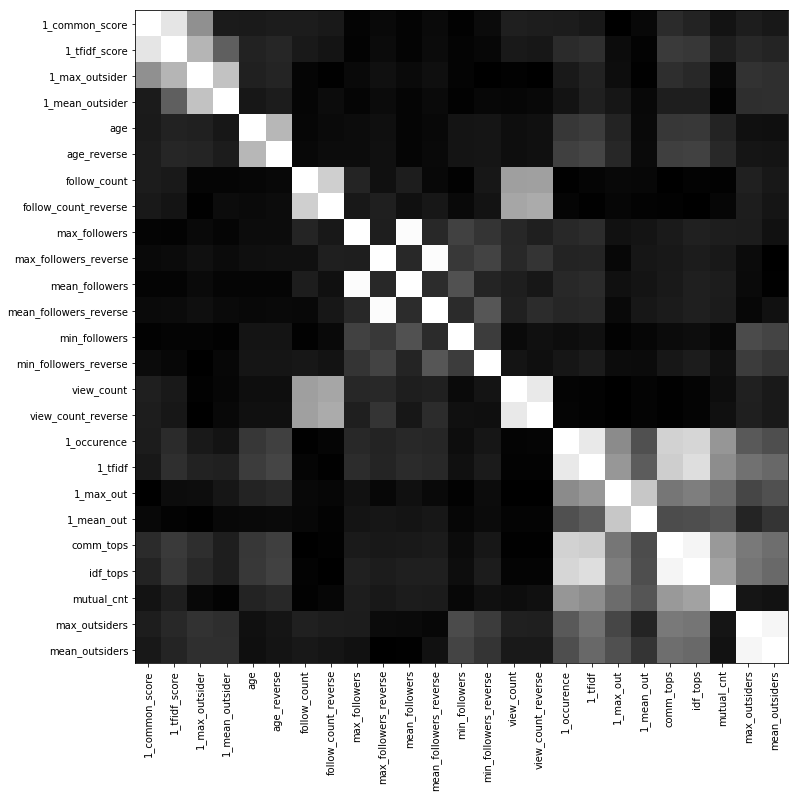

In [41]:
plt.figure(figsize=(12,12))
plt.imshow(np.abs(corrs), cmap='gray', interpolation=None)
plt.xticks(range(corrs.shape[0]), columns, rotation=90)
plt.yticks(range(corrs.shape[0]), columns)
plt.show()

In [52]:
from sklearn.decomposition import PCA

In [43]:
from sklearn.model_selection import StratifiedKFold

In [49]:
from sklearn.metrics import make_scorer, log_loss

In [61]:
trains = []
tests = []

for train, test in skf.split(keys, y):
    
    lr = pip.fit(keys[train], y[train])
    trains.append(lr.score(keys[train], y[train]))
    tests.append(lr.score(keys[test], y[test]))

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
def score_on_train_and_test(clf, train_x, train_y, test_x, test_y):
    
    clf.fit(train_x, train_y)
    
    return [clf.score(train_x, train_y), clf.score(test_x, test_y)]

In [73]:
from sklearn.externals.joblib import Parallel, delayed

In [77]:
def train_val_score(clf, X, y, cv=5):
    
    skf = StratifiedKFold(n_splits=cv)
    
    scores = Parallel(n_jobs=-1)(delayed(score_on_train_and_test)(clf, keys[train], y[train], keys[test], y[test]) for train, test in skf.split(keys, y))
    return scores

In [81]:
train_means = np.zeros((2, 5))
test_means = np.zeros((2, 5))

for i, clf in enumerate([LogisticRegression(C=5), RandomForestClassifier(n_estimators=50, max_depth=15)]):
    
    for j, vectorizer in enumerate([QuestionTextVectorizer(n_grams=1, qdict=qdict), StatsVectorizer(qdict), 
                   WordInTopicVectorizer(qdict, n_grams=1), TopicVectorizer(qdict), union]):
        
        pip = make_pipeline(vectorizer, clf)
        scores = np.asarray(train_val_score(pip, keys, y))
        means = np.mean(scores, axis=0)
        train_means[i, j] = means[0]
        test_means[i, j] = means[1]
        
        print(i, j)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4


In [230]:
def choose_best(X, fit_scores, threshold, pass_corrs_in_lieu_of_features=True):
    
    N = X.shape[1]
    corrs_bool = np.corrcoef(X, rowvar=0) > threshold
    
    to_pass = list(range(N))
    for i in range(N):
        for j in range(i+1, N):
            
            if corrs_bool[i, j]:
                
                to_remove = i if fit_scores[i] < fit_scores[j] else j
                if to_remove in to_pass:
                    to_pass.remove(to_remove)
                
                
    return to_pass

In [231]:
from sklearn.model_selection import RandomizedSearchCV

In [232]:
params = {'n_estimators': range(100, 500, 10), 'max_depth': [None] + [5, 10, 15], 
          'max_features': range(10, 25)}

In [268]:
union = make_union(QuestionTextVectorizer(n_grams=1, qdict=qdict), StatsVectorizer(qdict), 
                   WordInTopicVectorizer(qdict, n_grams=1), TopicVectorizer(qdict))

In [269]:
searcher = RandomizedSearchCV(make_pipeline(union, RandomForestClassifier()), param_distributions=params, 
                             cv=3, n_iter=15, verbose=2, n_jobs=-1)

In [271]:
pip = make_pipeline(union, RandomForestClassifier(n_estimators=50, max_depth=15))

In [272]:
pip.fit(keys, y)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('questiontextvectorizer', <__main__.QuestionTextVectorizer object at 0x7faa1dcecf28>), ('statsvectorizer', <__main__.StatsVectorizer object at 0x7faa1dcecf60>), ('wordintopicvectorizer', <__main__.WordInTopicVectorizer object a...imators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [274]:
with open('output/output00.txt', 'r') as f:
    O = f.read().split('\n')

In [278]:
to_predict = [row.split() for row in to_predict]

In [284]:
test_lab = np.asarray([int(row.split()[2]) for row in O[:-1]])

In [287]:
(pip.predict(to_predict) == test_lab).mean()

0.78066666666666662

In [315]:
scores = test_features_by_permutation(rfc, all_features, y, shuffles=50)